## Step 0: Install and Import Dependencies

In [ ]:
import os
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

if torch.cuda.is_available():
  torch.cuda.set_device(0)
  dev = "cuda:0"
else:
  dev = "cpu"
print(dev)
device = torch.device(dev)

cuda:0


# Step 1: Get the Data

1.1. Download the Data from the Web (It will be a .zip file for this)

1.2. Extract the zip file

1.3. Delete the zip file


# Step 2: Define Transformations

1. Resize the images using `Resize()` to 224. We choose the images size to be 224 based on the ViT Paper

2. Convert to Tensor using `ToTensor()`

In [ ]:
BATCH_SIZE=64
# Define the train_transform using Compose
train_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Define the test_transform using Compose
test_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=train_transform, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=test_transform, download=True)
if(os.path.exists("./data/cifar-10-batches-py.zip")):
  os.remove( "./data/cifar-10-batches-py.zip")
# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 170498071/170498071 [00:12<00:00, 13562899.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


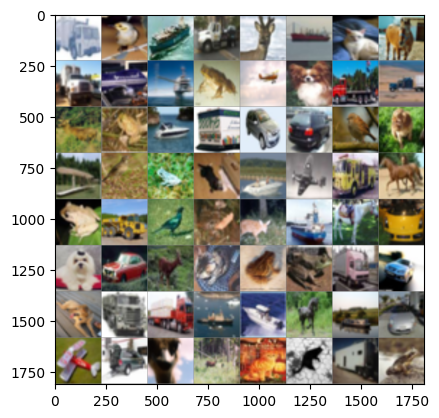

In [ ]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)
# print('  '.join(classes[labels[j]] for j in range(4)))

# Step 3: Create Dataset and DataLoader

We can use PyTorch's ImageFolder DataSet library to create our Datasets.

For ImageFolder to work this is how your data folder needs to be structured.

```markdown
data
└── CIFAR-10
    └── train
        ├── airplanes
        ├── birds
        ├── cars
        ├── cats
        ├── deer
        ├── dogs
        ├── frogs
        ├── horses
        ├── ships
        └── trucks

We can visualize a few training dataset images and see their labels

# Understanding Vision Transformer

Let us take some time now to understand the Vision Transformer Architecture. This is the link to the original vision transformer paper: https://arxiv.org/abs/2010.11929.

Below you can see the architecture that is proposed in the image.

<img height = "430" src = "https://res.cloudinary.com/dltwftrgc/image/upload/v1686823579/Blogs/Vision-Transformer/Vision_Transformer_Architecture_woi9aw.png">

The Vision Transformer (ViT) is a type of Transformer architecture designed for image processing tasks. Unlike traditional Transformers that operate on sequences of word embeddings, ViT operates on sequences of image embeddings. In other words, it breaks down an input image into patches and treats them as a sequence of learnable embeddings.

At a broad level, what ViT does is, it:

1. **Creates Patch Emebeddings**
     1. Takes an input image of a given size $(H \times W \times C)$ -> (Height, Width, Channels)
     2. Breaks it down into $N$ patches of a given size: $P$ --> PATCH_SIZE
     3. Converts the patches into a **sequence** of learnable embeddings vectors: $E ∈ R^{(P^2C) \times D}$
     4. Prepends a **classification token embedding vector** to the learnable embeddings vectors
     5. Adds the **position embeddings** to the learnable embeddings: $E_{pos} \in R^{(N+1) \times D}$
   
2. Passes embeddings through **Transformer Blocks**:

     - The patch embeddings, along with the classification token, are passed through multiple Transformer blocks.
     - Each Transformer block consists of a MultiHead Self-Attention Block (MSA Block) and a Multi-Layer Perceptron Block (MLP Block).
     - Skip connections are established between the input to the Transformer block and the input to the MSA block, as well as between the input to the MLP block and the output of the MLP block. These skip connections help mitigate the vanishing gradient problem as more Transformer blocks are added.
  
3. Performs **Classification**:

     - The final output from the Transformer blocks is passed through an MLP block.
     - The classification token, which contains information about the input image's class, is used to make predictions.


We will dive into each of these steps in detail, starting with the crucial process of creating patch embeddings.

---


# Step 4: Create Patch Embedding Layer

For the ViT paper we need to perform the following functions on the image before passing to the MultiHead Self Attention Transformer Layer

1. Convert the image into patches of 16 x 16 size.
2. Embed each patch into 768 dimensions. So each patch becomes a `[1 x 768] ` Vector. There will be $N = \frac{H \times W}{P^2}$ number of patches for each image. This results in an image that is of the shape `[14 x 14 x 768]`
3.  Flatten the image along a single vector. This will give a `[196 x 768]` Matrix which is our Image Embedding Sequence.
4. Prepend the Class Token Embeddings to the above output
5. Add the Position Embeddings to the Class Token and Image Embeddings.




![Vision Tranformer Steps](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-patch-embedding-animation.gif)

In [ ]:
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)

# the image width and image height should be divisible by patch size. This is a check to see that.

assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE == 0, print(
    "Image Width is not divisible by patch size"
)

## Step 4.1 Converting the image into patches of 16 x 16 and creating an embedding vector for each patch of size 768.

This can be accomplished by using a Conv2D Layer with a kernel_size equal to patch_size and a stride equal to patch_size

<img src = "https://res.cloudinary.com/dltwftrgc/image/upload/v1686832476/Blogs/Vision-Transformer/CNN_Flatten_vfq1q6.png" width = "600">
<!-- ![Convolution plus Flatten](https://res.cloudinary.com/dltwftrgc/image/upload/v1686832476/Blogs/Vision-Transformer/CNN_Flatten_vfq1q6.png) -->



## Put the PatchEmbedddingLayer Together

We will inherit from the PyTorch `nn.Module` to create our custom layer which takes in an image and throws out the patch embeddings which consists of the Image Embeddings, Class Token Embeddings and the Position Embeddings.

In [ ]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(
            torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True)
        )
        self.position_embeddings = nn.Parameter(
            torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True)
        )

    def forward(self, x):
        output = (
            torch.cat(
                (
                    self.class_token_embeddings,
                    self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1))),
                ),
                dim=1,
            )
            + self.position_embeddings
        )
        return output

## Step 5. Creating the Multi-Head Self Attention (MSA) Block.

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims = 768, # Hidden Size D in the ViT Paper Table 1
               num_heads = 12,  # Heads in the ViT Paper Table 1
               attn_dropout = 0.0 # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

## Step 6. Creating the Machine Learning Perceptron (MLP) Block

In [ ]:
class MachineLearningPerceptronBlock(nn.Module):
  def __init__(self, embedding_dims, mlp_size, mlp_dropout):
    super().__init__()
    self.embedding_dims = embedding_dims
    self.mlp_size = mlp_size
    self.dropout = mlp_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dims, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dims),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self, x):
    return self.mlp(self.layernorm(x))

## Step 7. Putting together the Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims = 768,
               mlp_dropout=0.1,
               attn_dropout=0.0,
               mlp_size = 3072,
               num_heads = 12,
               ):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    self.mlp_block = MachineLearningPerceptronBlock(embedding_dims = embedding_dims,
                                                    mlp_size = mlp_size,
                                                    mlp_dropout = mlp_dropout,
                                                    )

  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x

## Step 8. Creating the ViT Model

In [ ]:
class ViT(nn.Module):
  def __init__(self, img_size = 224,
               in_channels = 3,
               patch_size = 16,
               embedding_dims = 768,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 12,
               num_classes = 1000):
    super().__init__()

    self.patch_embedding_layer = PatchEmbeddingLayer(in_channels = in_channels,
                                                     patch_size=patch_size,
                                                     embedding_dim = embedding_dims)

    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                              mlp_dropout = mlp_dropout,
                                              attn_dropout = attn_dropout,
                                              mlp_size = mlp_size,
                                              num_heads = num_heads) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                    nn.Linear(in_features = embedding_dims,
                                              out_features = num_classes))

  def forward(self, x):
    return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])

## Loss Function and Optimiser

In [ ]:
model= ViT()
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training Loop


In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/CIFAR-10{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100

best_vloss = 1_000_000.
for epoch in range(EPOCHS):
  print('EPOCH {}:'.format(epoch_number + 1))
  model.train(True)
  running_loss = 0.
  last_loss = 0.
  for step, batch in enumerate(training_loader):
        inputs, labels = batch
        inputs,labels=inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if step % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(step + 1, last_loss))
            tb_x = epoch_number * len(training_loader) + step + 1
            writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
  running_vloss = 0.0

  model.eval()

  with torch.no_grad():
      for i, vdata in enumerate(validation_loader):
          vinputs, vlabels = vdata
          voutputs = model(vinputs)
          vloss = loss_fn(voutputs, vlabels)
          running_vloss += vloss

  avg_vloss = running_vloss / (step + 1)
  print('LOSS train {} valid {}'.format(last_loss, avg_vloss))

  writer.add_scalars('Training vs. Validation Loss',
                  { 'Training' : last_loss, 'Validation' : avg_vloss },
                  epoch_number + 1)
  writer.flush()

  if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      model_path = 'model_{}_{}'.format(epoch_number,timestamp)
      torch.save(model.state_dict(), model_path)

  epoch_number += 1

EPOCH 1:


RuntimeError: ignored